In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os

In [ ]:
!pip install jiwer
!pip install trectools
!pip install rouge_score
!pip install datasets transformers torch evaluate nltk rouge_score

In [ ]:
df = pd.read_csv('/kaggle/input/corpus-of-russian-news-articles-from-lenta/lenta-ru-news.csv')
df

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


In [ ]:
df = df[['title', 'text']]
df = df.dropna()

df['len_text'] = df['text'].apply(len)
df['len_title'] = df['title'].apply(len)

array([[<AxesSubplot:title={'center':'len_text'}>,
        <AxesSubplot:title={'center':'len_title'}>]], dtype=object)

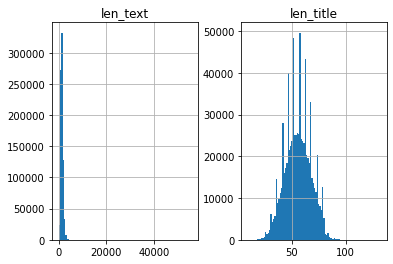

In [ ]:
df.hist(['len_text', 'len_title'], bins=100)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 3000.0)

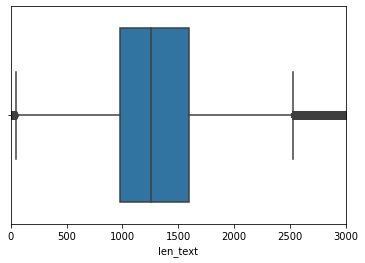

In [ ]:
sns.boxplot(df['len_text'])
plt.xlim([0, 3000])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 100.0)

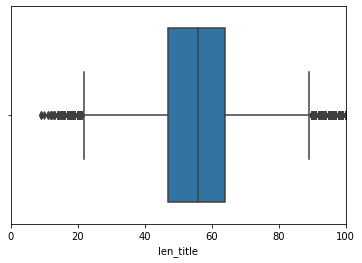

In [ ]:
sns.boxplot(df['len_title'])
plt.xlim([0, 100])

In [ ]:
import torch
import nltk
from datasets import load_dataset
from transformers import AutoTokenizer
nltk.download('punkt')
import string
from datasets import Dataset
from transformers import T5ForConditionalGeneration, T5Tokenizer

prefix = ""
max_input_length = 1000
max_target_length = 100

tokenizer = T5Tokenizer.from_pretrained('cointegrated/rut5-base-absum')

def cut_text(s):
    if len(s) > 1000:
        s = s[0:1000]
    return s

def cut_title(s):
    if len(s) > 100:
        s = s[0:100]
    return s

df['text'] = df['text'].apply(cut_text)
df['title'] = df['title'].apply(cut_title)

pd_ds = df[['text', 'title']]

def clean_text(text):
  sentences = nltk.sent_tokenize(text.strip())
  sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
  sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                 if len(sent) > 0 and
                                 sent[-1] in string.punctuation]
  text_cleaned = "\n".join(sentences_cleaned_no_titles)
  return text_cleaned

def tokinize_func(examples):
  texts_cleaned = [clean_text(text) for text in examples["text"]]
  inputs = [prefix + text for text in texts_cleaned]
  model_inputs = tokenizer(inputs, padding='max_length', max_length=max_target_length, truncation=True)

  # Setup the tokenizer for targets
  with tokenizer.as_target_tokenizer():
    labels = tokenizer(examples["title"], padding='max_length', max_length=max_target_length, truncation=True)

  model_inputs["labels"] = labels["input_ids"]
  return model_inputs

dataset = Dataset.from_pandas(pd_ds)
dataset = dataset.select(range(500))

dataset = dataset.map(tokinize_func, batched=True)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Downloading:   0%|          | 0.00/808k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/315 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
dataset

Dataset({
    features: ['text', 'title', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 500
})

In [ ]:
# train test split
test_part = 0.2

dataset_train = dataset.select(range(int(len(dataset)*(1-test_part)))).shuffle(seed=42)
dataset_test = dataset.select(range(int(len(dataset)*test_part))).shuffle(seed=42)

In [ ]:
from transformers import pipeline, AutoModel

model = T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-absum")

Downloading:   0%|          | 0.00/753 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/932M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
import numpy as np
import evaluate

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = TrainingArguments(output_dir="/kaggle/tmp/test_trainer",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=1,
                                  eval_accumulation_steps=10)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    data_collator=data_collator,
)

In [ ]:
dataset_test

Dataset({
    features: ['text', 'title', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:128'
os.environ["WANDB_DISABLED"] = "True"

trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, title, text. If __index_level_0__, title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 400
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 50
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Epoch,Training Loss,Validation Loss
1,No log,0.307464


The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: __index_level_0__, title, text. If __index_level_0__, title, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=50, training_loss=0.45580032348632815, metrics={'train_runtime': 1440.1548, 'train_samples_per_second': 0.278, 'train_steps_per_second': 0.035, 'total_flos': 53104435200000.0, 'train_loss': 0.45580032348632815, 'epoch': 1.0})

In [ ]:
trainer.save_model("/kaggle/working/ruT5_title_generator")

Saving model checkpoint to /kaggle/working/ruT5_title_generator
Configuration saved in /kaggle/working/ruT5_title_generator/config.json
Model weights saved in /kaggle/working/ruT5_title_generator/pytorch_model.bin


In [ ]:
tokenizer.save_pretrained("/kaggle/working/ruT5_title_generator_tokenizer")

tokenizer config file saved in /kaggle/working/ruT5_title_generator_tokenizer/tokenizer_config.json
Special tokens file saved in /kaggle/working/ruT5_title_generator_tokenizer/special_tokens_map.json


('/kaggle/working/ruT5_title_generator_tokenizer/tokenizer_config.json',
 '/kaggle/working/ruT5_title_generator_tokenizer/special_tokens_map.json',
 '/kaggle/working/ruT5_title_generator_tokenizer/spiece.model',
 '/kaggle/working/ruT5_title_generator_tokenizer/added_tokens.json')

In [ ]:
def summarize(
    text, n_words=None, compression=None,
    max_length=1000, num_beams=3, do_sample=False, repetition_penalty=10.0, 
    **kwargs
            ):
    if n_words:
        text = '[{}] '.format(n_words) + text
    elif compression:
        text = '[{0:.1g}] '.format(compression) + text
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    with torch.inference_mode():
        out = model.generate(
            **x, 
            max_length=max_length, num_beams=num_beams, 
            do_sample=do_sample, repetition_penalty=repetition_penalty, 
            **kwargs
        )
    return tokenizer.decode(out[0], skip_special_tokens=True)

In [ ]:
def predict(i=1):
    text = dataset_test[i]['text']
    title = dataset_test[i]['title']
    predicted = summarize(text)
    
    print('Новость: ', text, '\n')
    print('Оригинальное название: ', title, '\n')
    print('Сгенерированное название: ', predicted, '\n')

In [ ]:
predict(5)

Новость:  Не успели утихнуть споры об организаторах взрыва на Манежной площади, как у москвичей появился новый повод для беспокойства. Как сообщают РИА "Новости" и ИНТЕРФАКС, сегодня утром, в 8.15, на 6-м пути Павелецкого вокзала Москвы был обнаружен предмет, похожий на взрывное устройство. Прибывший на место обнаружения подозрительного пакета кинолог с собакой подтвердил вероятность наличия в нем взрывчатки. В 8.55 на место обнаружения опасной находки прибыла спецгруппа УФСБ по Москве и Московской области. С вокзала эвакуированы все пассажиры. Кроме того, прекращена подача электропоездов на 6-й и соседние с ним железнодорожные пути. Сам вокзал окружен двойным оцеплением сотрудников милиции. Как сообщил ИТАР-ТАСС оперативный дежурный МЧС России, пакет помещен в специальное устройство-нейтрализатор. В настоящее время пакет изучают специалисты. Между тем, по информации Мэрии Москвы, напоминающий самодельное взрывное устройство предмет (два пакета, связанные между собой проводками) был на

In [ ]:
predict(50)

Новость:  По данным ИТАР-ТАСС,сторонники Станислава Дерева, 11-е сутки стоящие на Центральнойплощади Черкесска, пока не откликнулись на обращение председателяправительства РФ Владимира Путина и заявление переговорныхделегаций Семенова и Дерева о прекращении митингов во имясохранения спокойствия в республике. Еще в конце августа распоряжение о прекращении митингаподписал временно исполняющий обязанности главыКарачаево-Черкесии Валентин Власов, а Черкесский городской судотменил разрешение Черкесской городской администрации на проведение митинга. Митингующие не покидают площадь даже на ночь. Станислав Дерев,выступивший в воскресенье перед ними по итогам своей поездки вМоскву, подтвердил свою прежнюю позицию, что если итоги выборовне будут отменены, то абазины, черкесы, ряд других народовоставляют за собой право провозгласить Черкесскую автономию свыходом ее из состава Карачаево-Черкесии. Обстановку в городе трудно назвать спокойной: сегодня в пять часов утрабыл совершен поджог кафе "Цезар